**This notebook trains and evaluates the baseline model**

In [389]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook
import sys
from sklearn.metrics import roc_auc_score
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks import SaveModelCallback

Training parameters

In [390]:
BATCH_SIZE = 128
sz = 256
NUM_WORKERS = 32
model_name = '20190626-0-densenet121'

Use data augmentations that mimic the hue and color saturation variance caused by the different scanning isntruments and staining procedures. 

In [479]:
albumentations_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ],p=0.8),
    albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=20, always_apply=False, p=0.5),
    albumentations.RandomGamma(gamma_limit=(80, 150), always_apply=True, p=1),
    #albumentations.augmentations.transforms.MedianBlur(blur_limit=7, always_apply=False, p=0.1),
])

albumentations_transform_validation = albumentations.Compose([
    #albumentations.RandomRotate90(p=0.5),
    #albumentations.Transpose(p=0.5),
])

### Show training augmentations

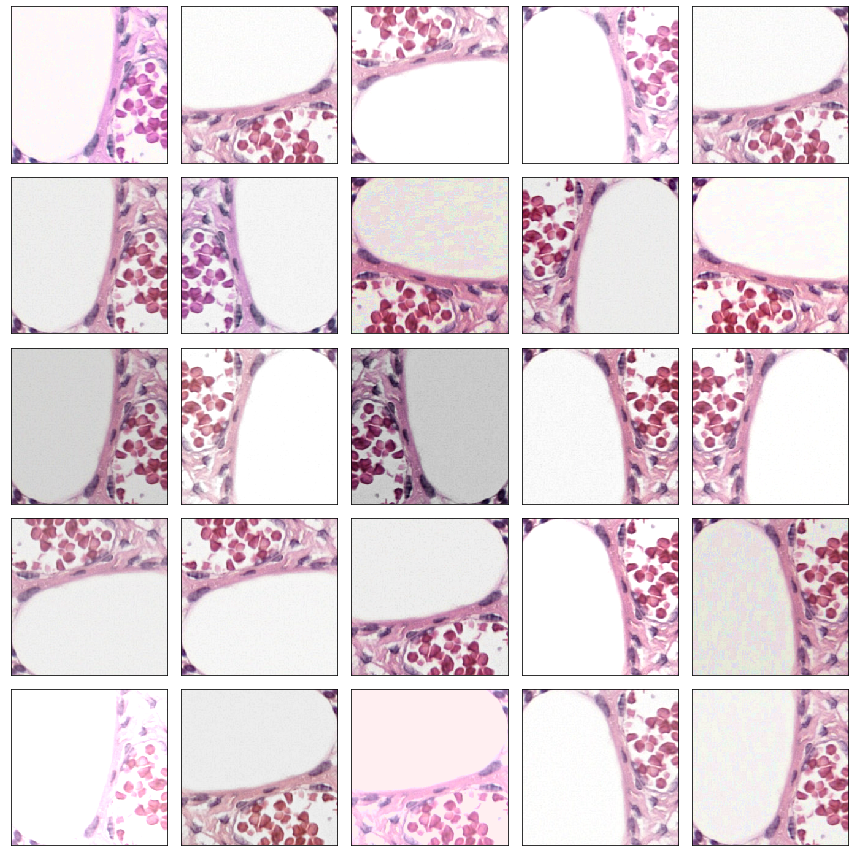

In [480]:
# sample image
img = cv2.imread('data/patches/1066240043904_0.png')

fig, ax = plt.subplots(5,5, figsize=(12,12))
for i in range(5):
    for j in range(5):
        augmented = albumentations_transform(image=img)
        ax[i,j].imshow(augmented['image'])
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

Load dataframes

In [83]:
validation_center = 0
df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
df['is_valid'] = df.center == validation_center
len(df)

134710

- Use only 0-level images in this model.
- Normalize with Imagenet stats because the pretrained model has been trained with similar normalization.

Custom image lists

In [481]:
class CustomImageList(ItemList):
    "`ItemList` suitable for computer vision that uses augmentations for training items but not for validation items"
    _bunch,_square_show,_square_show_res = ImageDataBunch,True,True
    def __init__(self, *args, df_copy=None, validation_colname="", data_dir='',data_suffix='', convert_mode='RGB', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.df_copy,self.validation_colname,self.data_dir,self.data_suffix, self.convert_mode,self.after_open = df_copy,validation_colname,data_dir,data_suffix,convert_mode,after_open
        if(df_copy is None):
            print('Empty df copy')
        self.copy_new.append('df_copy')
        self.copy_new.append('validation_colname')
        self.copy_new.append('data_dir')
        self.copy_new.append('data_suffix')
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 3,{}

    def get(self, i):
        fn = super().get(i)
        res = self.open(fn)
        self.sizes[i] = res.size
        return res
    
    def open(self, fn)->Image:
        img = cv2.imread(fn)
        # Apply transformations
        augmented = albumentations_transform_validation(image=img) if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix, ''))][self.validation_colname]).any() else albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
    
    @classmethod
    def from_df_custom(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix:str='', **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or ''
        res = super().from_df(df, path=path, cols=cols, **kwargs, data_dir=path, data_suffix=suffix)
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add(pref, res.items.astype(str)), suffix)
        return res
    
    def reconstruct(self, t:Tensor): return Image(t.float().clamp(min=0,max=1))

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [482]:
# Create ImageDataBunch using fastai data block API
imgDataBunch = (CustomImageList.from_df_custom(path='data/patches/',
                                        df=df,
                                        suffix='_0.png', 
                                        df_copy=df, 
                                        validation_colname='is_valid')
                .split_from_df('is_valid')
                #How to split in train/valid? CV index
                .label_from_df(cols='tumorLabel')
                #Where are the labels?
                .transform(tfms=[[],[]], size=sz)
                # We have our custom transformations implemented in the image loader but we could apply transformations also here
                # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
                # convert to databunch
                .normalize(imagenet_stats))

**Plot samples from train and valid. sets for sanity check**

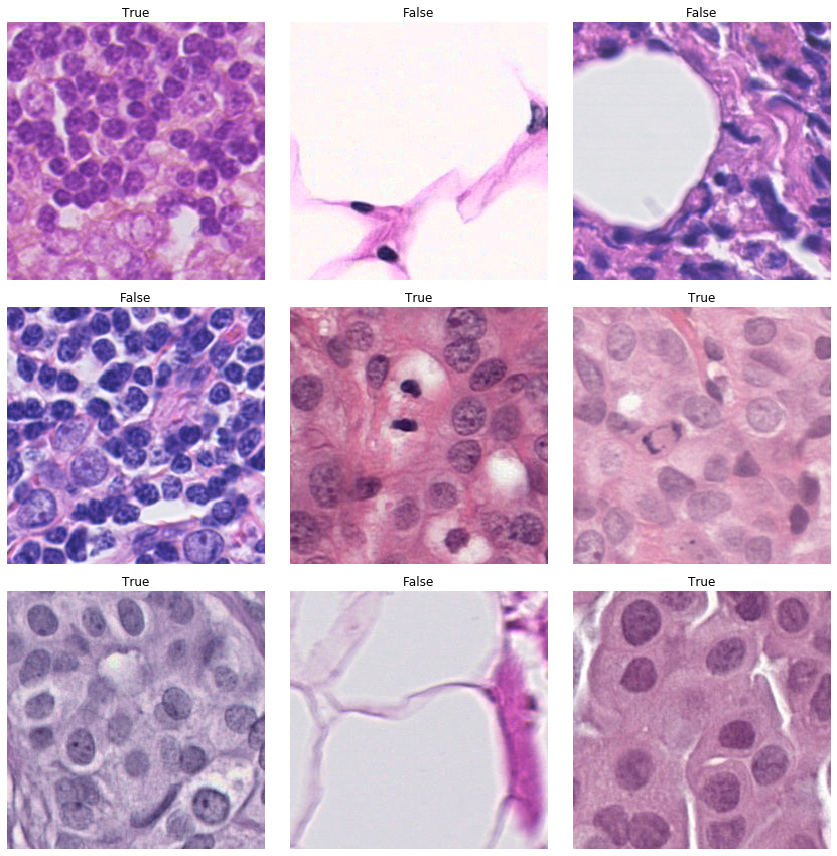

In [108]:
imgDataBunch.show_batch(rows=3, ds_type=DatasetType.Train)

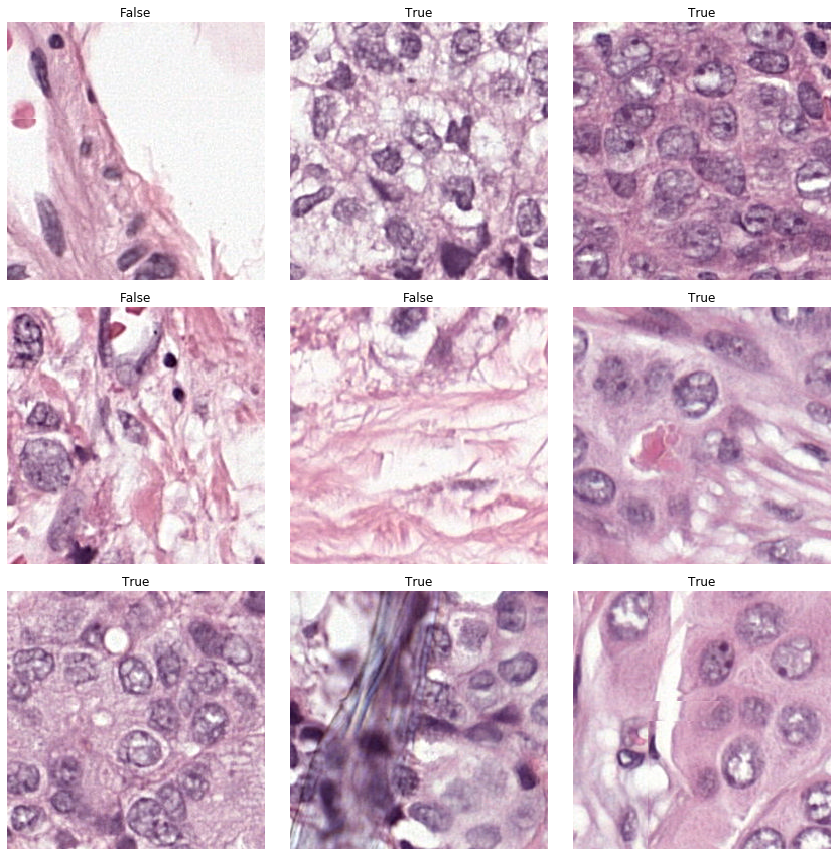

In [483]:
imgDataBunch.show_batch(rows=3, ds_type=DatasetType.Valid)

### Training

In [484]:
learner = cnn_learner(imgDataBunch,
                      models.densenet121,
                      pretrained=True,
                      path='.',
                      metrics=[accuracy],
                      ps=0.8,
                      callback_fns=ShowGraph)

learner.crit=nn.BCEWithLogitsLoss()

In [111]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


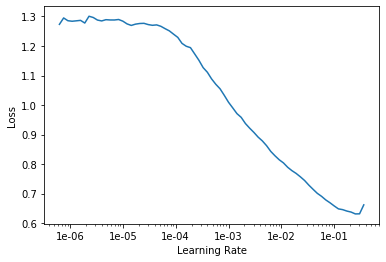

In [112]:
# and plot the losses of the first cycle
learner.recorder.plot()

Learning rate 1e-2 seems like a good initial learning rate. The LR test shows that it's still descending in that area.

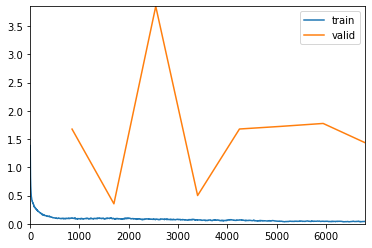

Better model found at epoch 0 with val_loss value: 1.677230715751648.
Better model found at epoch 1 with val_loss value: 0.3542934060096741.


In [113]:
learner.fit_one_cycle(8,
                      8e-3,
                     callbacks=[
                          SaveModelCallback(learner,
                                            every='improvement',
                                            monitor='val_loss',
                                            name= model_name + '_best_stage-1')
                      ])

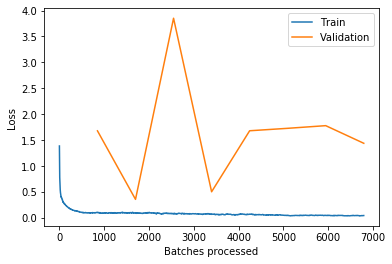

In [114]:
learner.recorder.plot_losses()

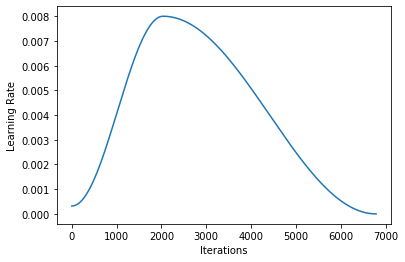

In [184]:
learner.recorder.plot_lr()

In [ ]:
learner.save(model_name + '_last_stage-1')

In [485]:
learner.load(model_name + '_best_stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (108762 items)
x: CustomImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
True,True,False,True,False
Path: data/patches;

Valid: LabelList (25948 items)
x: CustomImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
False,True,True,False,False
Path: data/patches;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

# Validation

In [138]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.861453652381897 %.


TTA (test time augmentation) will improve this

In [140]:
preds,y, loss = learner.TTA(ds_type=DatasetType.Valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy with TTA is {0} %.'.format(acc))

The accuracy with TTA is 0.8774086833000183 %.


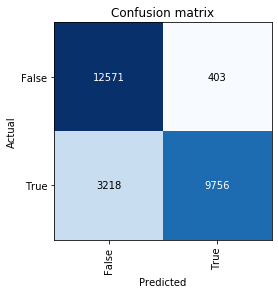

In [141]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [142]:
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Normal','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

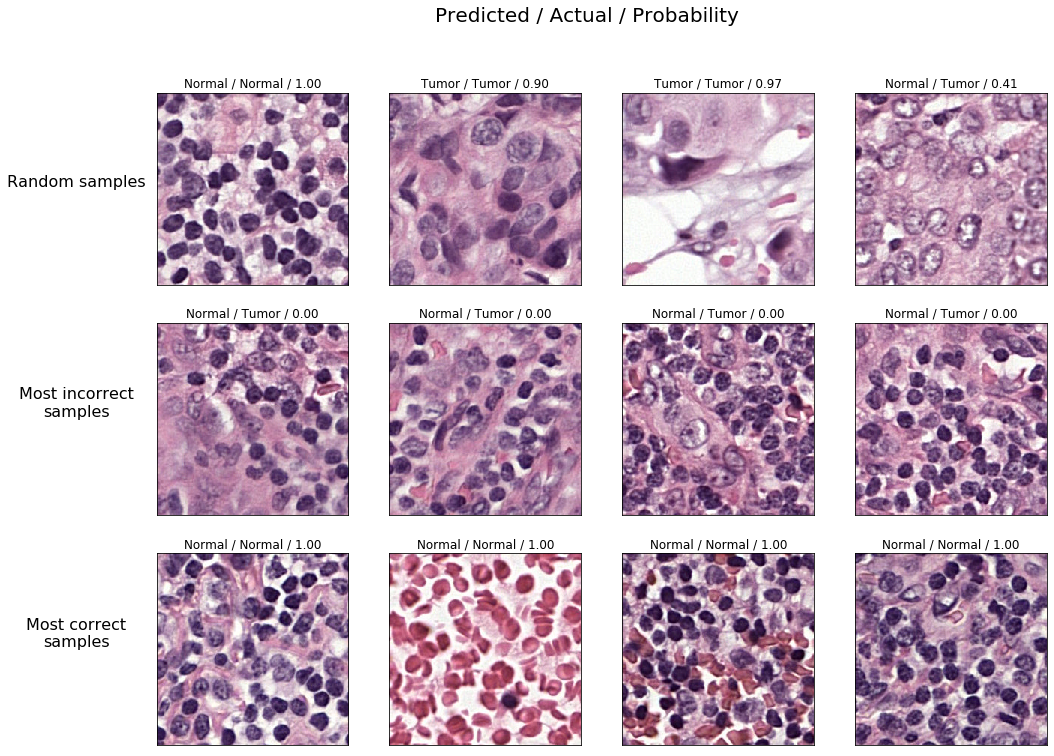

In [143]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Normal','Tumor'])

In [531]:
type(learner.model.eval()[0][0][11])

torch.nn.modules.batchnorm.BatchNorm2d

In [486]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat, depth=0):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0][0][depth]) as hook_a: 
        with hook_output(m[0][0][depth], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [496]:
def colorize_binary_image(img, color_channel:int=1, max_value=1):
    '''
    Colorize binary image to set color channel.
    Only 0 and 1 works with the color channel'''
    empty_c = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8) 
    alpha_c = np.ones((img.shape[0], img.shape[1], 1), dtype=np.uint8)
    sc_factor = 255/5e-6 if max_value < 5e-6 else 255/max_value
    img *= sc_factor
    img = torch.clamp(img, 0, 255, out=None)
    img = img.reshape((img.shape[0], img.shape[1], 1)).numpy().astype(np.uint8)
    alpha_img = np.concatenate([empty_c, img, empty_c, alpha_c], axis=2) if color_channel == 1 else np.concatenate([ img, empty_c, empty_c, alpha_c], axis=2)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            alpha_img[x, y, 3] = 0 if alpha_img[x, y, color_channel] == 0 else alpha_img[x, y, color_channel]*2//3
    return alpha_img

In [501]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, depth=0, manual_scaler=None):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    colorImage = image2np(oneBatch_im.data)
    
    # attach hooks
    #hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    hook_a_tumor,hook_g_tumor = hooked_backward(m, oneBatch, 1, depth)
    # get convolutional activations and average from channels
    acts_tumor = hook_a_tumor.stored[0].cpu()

    # Grad-CAM
    grad_tumor = hook_g_tumor.stored[0][0].cpu()
    grad_chan_tumor = grad_tumor.mean(1).mean(1)
    mult_tumor = F.relu((acts_tumor*grad_chan_tumor[...,None,None]).mean(0))
    
    hook_a_normal,hook_g_normal = hooked_backward(m, oneBatch, 0, depth)
    # get convolutional activations and average from channels
    acts_normal = hook_a_normal.stored[0].cpu()

    # Grad-CAM
    grad_normal = hook_g_normal.stored[0][0].cpu()
    grad_chan_normal = grad_normal.mean(1).mean(1)
    mult_normal = F.relu((acts_normal*grad_chan_normal[...,None,None]).mean(0))
    
    scaler = max(mult_tumor.max(), mult_normal.max())
    if (manual_scaler is not None):
        scaler = manual_scaler
    
    return (colorize_binary_image(mult_tumor, 0, max_value=scaler),
            colorize_binary_image(mult_normal, 1, max_value=scaler),
            colorImage) #cvIm

In [517]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor'], depth=0):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #mask_alpha = 0.3
    tissue_alpha = 0.75
    manual_scaler = None# 1e-4
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,13))
    fig.suptitle('Layer depth: {0}\nClass activation map where: Green=Normal, Red=Tumor\nPredicted / Actual / Probability'.format(depth),fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act_tumor, act_normal, im = getHeatmap(idx, depth, manual_scaler)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im, alpha=tissue_alpha)
        #ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[0,i].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act_tumor, act_normal, im = getHeatmap(idx, depth, manual_scaler)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im, alpha=tissue_alpha)
        #ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[1,i].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act_tumor, act_normal, im = getHeatmap(idx, depth, manual_scaler)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im, alpha=tissue_alpha)
        #ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[2,i].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

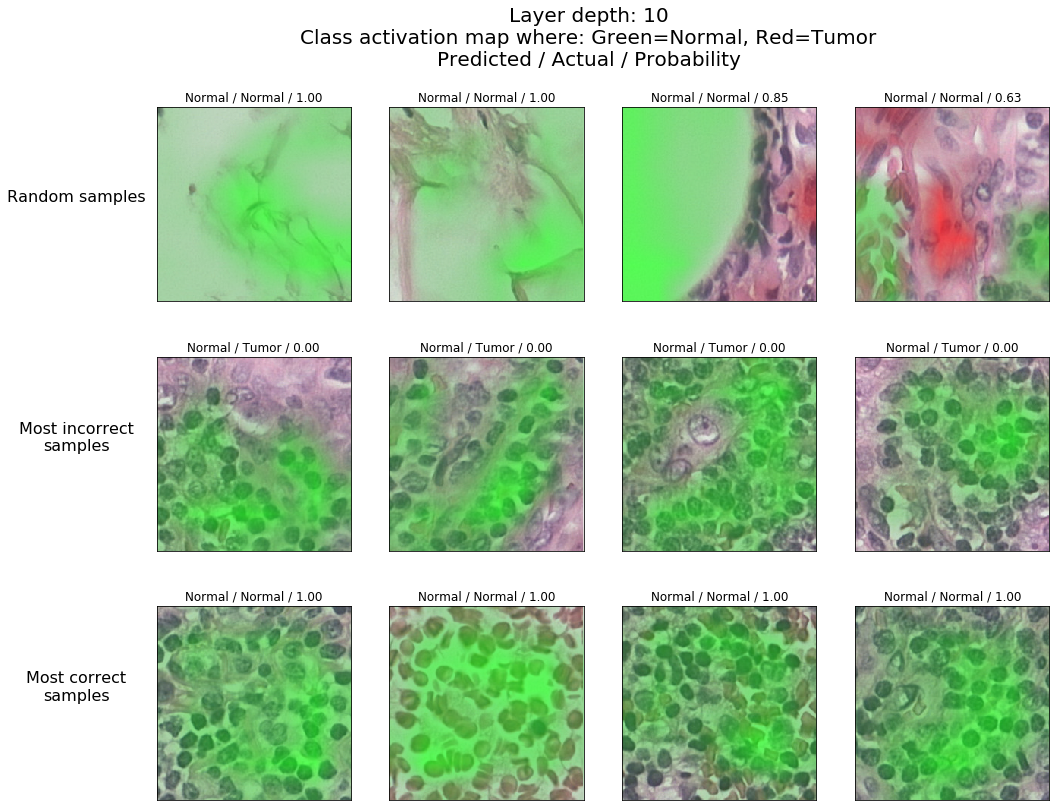

In [518]:
plot_heatmap_overview(interp, ['Normal','Tumor'], 10)

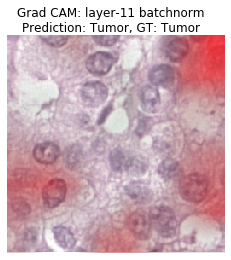

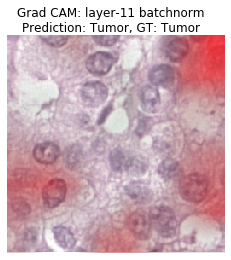

In [550]:
from IPython import display
import time
%matplotlib inline

tissue_alpha = 0.7
classes = ['Normal','Tumor']
manual_scaler = 1e-5

idx = 54
while(idx < 55):
    for d, layer_depth in enumerate(range(1,12)):#[2,4,6,8,10]):    
        act_tumor, act_normal, im = getHeatmap(idx, layer_depth)
        H,W = im.shape[:2]
        
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)

        plt.clf()
        plt.suptitle('Grad CAM: layer-{0} {3}\nPrediction: {1}, GT: {2}'.format(layer_depth,
                                                                                           classes[interp.pred_class[idx]],
                                                                                           classes[cl],
                                                                                            str(type(learner.model.eval()[0][0][layer_depth])).split('.')[3].strip('\'>')))
        plt.imshow(im, alpha=tissue_alpha)
        plt.imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        plt.imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')

        plt.axis('off')
        plt.savefig('img/class_activations_1_' + str(d)+'.png')
        #frame update
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1. / 20.)
        
    idx += 1

## AUC

In [148]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.981899305720333


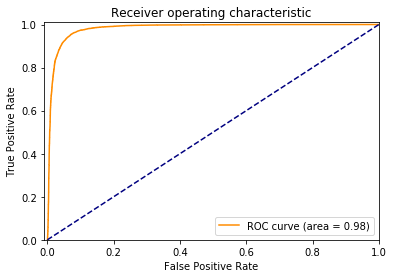

In [149]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Visualize model

In [551]:
import torch.onnx

In [553]:
dummy_input = torch.randn(BATCH_SIZE, 3, 256, 256).cuda()

# Providing input and output names sets the display names for values
# within the model's graph. Setting these does not change the semantics
# of the graph; it is only for readability.
#
# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
# The keyword argument verbose=True causes the exporter to print out a human-readable representation of the network

input_names = [ "image_input_1" ]
output_names = [ "prediction_output_1" ]
torch.onnx.export(learner.model, dummy_input, 'models/' + model_name + '.onnx', verbose=True, input_names=input_names, output_names=output_names)

graph(%image_input_1 : Float(128, 3, 256, 256),
      %0.0.conv0.weight : Float(64, 3, 7, 7),
      %0.0.norm0.weight : Float(64),
      %0.0.norm0.bias : Float(64),
      %0.0.norm0.running_mean : Float(64),
      %0.0.norm0.running_var : Float(64),
      %0.0.norm0.num_batches_tracked : Long(),
      %0.0.denseblock1.denselayer1.norm1.weight : Float(64),
      %0.0.denseblock1.denselayer1.norm1.bias : Float(64),
      %0.0.denseblock1.denselayer1.norm1.running_mean : Float(64),
      %0.0.denseblock1.denselayer1.norm1.running_var : Float(64),
      %0.0.denseblock1.denselayer1.norm1.num_batches_tracked : Long(),
      %0.0.denseblock1.denselayer1.conv1.weight : Float(128, 64, 1, 1),
      %0.0.denseblock1.denselayer1.norm2.weight : Float(128),
      %0.0.denseblock1.denselayer1.norm2.bias : Float(128),
      %0.0.denseblock1.denselayer1.norm2.running_mean : Float(128),
      %0.0.denseblock1.denselayer1.norm2.running_var : Float(128),
      %0.0.denseblock1.denselayer1.norm2.num_batc

In [555]:
import netron

In [558]:
netron.start('models/' + model_name + '.onnx', port=61493)

Serving 'models/20190626-0-densenet121.onnx' at http://localhost:61493


In [560]:
netron.stop()